# None as a product

## Feature engineering

In [32]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import xgboost

import sklearn
from sklearn.model_selection import train_test_split

import sys, os, gc, types
import time
from subprocess import check_output

sys.path.append('./utils')

from training import train as xgb_train
from plotting import plot_importance
from data import Data

In [2]:
root_paths = [
    "/data/kaggle-instacart/",
    "/Users/jiayou/Dropbox/珺珺的程序/Kaggle/Instacart/",
    "/Users/jiayou/Dropbox/Documents/珺珺的程序/Kaggle/Instacart/"
]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break
print(check_output(["ls", root]).decode("utf8"))

Build Feature.ipynb
CHANGELOG.md
F1 score optimization.ipynb
Instacart Data Exploration.ipynb
None handling.ipynb
Param Search Results.ipynb
Prediction.ipynb
README.md
Tasks.ipynb
Toy DF.ipynb
Training.ipynb
abt_test.csv
abt_train.csv
aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv
submission-v0.csv
submission-v1-r0.csv
submission-v1-r1.csv
submission-v3-test.csv
train-v3-test-histories.csv
train-v3-test-n0.bst
train-v3-test-params.csv
training-logs
utils



In [3]:
def load_data(path_data):
    priors = pd.read_csv(path_data + 'order_products__prior.csv', 
                     dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    train = pd.read_csv(path_data + 'order_products__train.csv', 
                    dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    orders = pd.read_csv(path_data + 'orders.csv', 
                         dtype={
                                'order_id': np.int32,
                                'user_id': np.int64,
                                'eval_set': 'category',
                                'order_number': np.int16,
                                'order_dow': np.int8,
                                'order_hour_of_day': np.int8,
                                'days_since_prior_order': np.float32})
    
    products = pd.read_csv(path_data + 'products.csv')
    aisles = pd.read_csv(path_data + "aisles.csv")
    departments = pd.read_csv(path_data + "departments.csv")
    sample_submission = pd.read_csv(path_data + "sample_submission.csv")
    
    return priors, train, orders, products, aisles, departments, sample_submission

In [4]:
class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))
            
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new


In [5]:
priors, train, orders, products, aisles, departments, sample_submission = load_data(root)

In [6]:
# down_sample = None
down_sample = 10
if down_sample is not None:
    priors = priors.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
    train = train.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
    
    orders = orders[orders.user_id % down_sample == 0]
    priors = priors[priors.user_id % down_sample == 0]
    train = train[train.user_id % down_sample == 0]
    
    priors.drop('user_id', inplace = True, axis=1)
    train.drop('user_id', inplace = True, axis=1)

## Calculate None for priors/train orders

In [7]:
none_priors = priors.groupby('order_id').reordered.agg({'contains_reorder': 'max'}).reset_index()
none_priors['is_none'] = 1 - none_priors.contains_reorder
none_priors.drop('contains_reorder', inplace = True, axis = 1)
none_priors

,order_id,is_none
0,3,0
1,4,0
2,12,0
3,16,0
4,18,0
5,43,0
6,50,0
7,64,0
8,73,0
9,88,0


## User feature engineering

In [8]:
priors_orders_detail = orders.merge(right=priors, how='inner', on='order_id').merge(products[['product_id','aisle_id']], how = 'left', on = 'product_id')
priors_orders_detail.loc[:,'user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1

In [9]:
agg_dict_2 = {'order_number':{'user_total_orders':'max'},
              'days_since_prior_order':{'user_sum_days_since_prior_order':'sum', 
                                        'user_mean_days_since_prior_order': 'mean'}}
users = ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

agg_dict_3 = {'reordered':
              {'user_reorder_ratio': 
               lambda x: sum(priors_orders_detail.ix[x.index,'reordered']==1)/
                         sum(priors_orders_detail.ix[x.index,'order_number'] > 1)},
              'product_id':{'user_total_products':'count', 
                            'user_distinct_products':'nunique'}}
us = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

add stats features begin ......
add stats features end ......
time lapsing 0.043270111083984375 s 

add stats features begin ......
add stats features end ......
time lapsing 79.35310077667236 s 



In [10]:
users['user_average_basket'] = users.user_total_products / users.user_total_orders

us = orders[orders.eval_set != "prior"]
# us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')

In [11]:
users.head()

,user_id,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,10,5,79.0,19.750000,0.355072,143,94,28.600000,1822501,train,6,0,19,30.0
1,20,4,15.0,5.000000,0.833333,22,7,5.500000,1980631,test,5,1,11,30.0
2,30,8,151.0,21.571428,0.625000,11,6,1.375000,62370,train,9,2,13,22.0
3,40,9,105.0,13.125000,0.739130,104,36,11.555556,2431024,test,10,0,8,7.0
4,50,67,357.0,5.409091,0.814318,453,89,6.761194,1750084,train,68,3,9,7.0


## User-None feature engineering

In [12]:
dsfo = orders.groupby('user_id').days_since_prior_order.cumsum().fillna(0)
orders['days_since_first_order'] = dsfo
max_days = orders.groupby('user_id').days_since_first_order.agg({'max_days':'max'}).reset_index()
orders = orders.merge(max_days, on = 'user_id', how = 'left')
orders['days_to_last_order'] = orders.max_days - orders.days_since_first_order
orders.drop(['days_since_first_order', 'max_days'], axis=1, inplace=True)

In [13]:
orders.head(6)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_to_last_order
0,1224907,10,prior,1,2,14,NaN,109.0
1,68288,10,prior,2,5,15,30.0,79.0
2,2115522,10,prior,3,3,19,12.0,67.0
3,83395,10,prior,4,3,15,14.0,53.0
4,1353310,10,prior,5,5,20,23.0,30.0
5,1822501,10,train,6,0,19,30.0,0.0


In [14]:
prior_orders = orders.merge(none_priors, on='order_id', how='inner')

In [15]:
# prior_orders = prior_orders[prior_orders.order_number != 1]
prior_orders = prior_orders[prior_orders.is_none == 1]
prior_orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_to_last_order,is_none
0,1224907,10,prior,1,2,14,NaN,109.0,1
5,947722,20,prior,1,1,10,NaN,45.0,1
9,375303,30,prior,1,1,13,NaN,173.0,1
14,2299885,30,prior,6,1,19,27.0,80.0,1
15,137318,30,prior,7,1,6,28.0,52.0,1
17,2570028,40,prior,1,0,9,NaN,112.0,1
26,1363380,50,prior,1,3,9,NaN,364.0,1
93,2769226,60,prior,1,0,20,NaN,204.0,1
101,2260493,70,prior,1,6,18,NaN,259.0,1
113,29902,70,prior,13,2,17,30.0,30.0,1


In [16]:
agg_dict_4 = {'order_number':{'un_order_count': 'count', 
                              'un_last_order_number':'max'}, 
              'days_to_last_order':{'un_days_since_last_order':'min'}}

data = ka_add_groupby_features_1_vs_n(df=prior_orders, group_columns_list=['user_id'], agg_dict=agg_dict_4)

data = data.merge(users, how='inner', on='user_id')

data['un_order_rate'] = (data.un_order_count - 1) / (data.user_total_orders - 1)
data['un_order_since_last_order'] = data.user_total_orders - data.un_last_order_number

data.head()

add stats features begin ......
add stats features end ......
time lapsing 0.011403083801269531 s 



,user_id,un_order_count,un_last_order_number,un_days_since_last_order,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,un_order_rate,un_order_since_last_order
0,10,1,1,109.0,5,79.0,19.750000,0.355072,143,94,28.600000,1822501,train,6,0,19,30.0,0.000000,4
1,20,1,1,45.0,4,15.0,5.000000,0.833333,22,7,5.500000,1980631,test,5,1,11,30.0,0.000000,3
2,30,3,7,52.0,8,151.0,21.571428,0.625000,11,6,1.375000,62370,train,9,2,13,22.0,0.285714,1
3,40,1,1,112.0,9,105.0,13.125000,0.739130,104,36,11.555556,2431024,test,10,0,8,7.0,0.000000,8
4,50,1,1,364.0,67,357.0,5.409091,0.814318,453,89,6.761194,1750084,train,68,3,9,7.0,0.000000,66


In [17]:
none_train = train.groupby('order_id').reordered.agg({'contains_reorder': 'max'}).reset_index()
none_train['is_none'] = 1 - none_train.contains_reorder
none_train.drop('contains_reorder', inplace = True, axis = 1)
none_train

,order_id,is_none
0,112,0
1,393,0
2,774,0
3,988,0
4,1620,0
5,1674,0
6,1764,0
7,2087,0
8,2415,0
9,2603,0


In [18]:
data = data.merge(none_train[['order_id', 'is_none']], on=['order_id'], how='left')

In [19]:
mask = data.un_last_order_number == 1
data.un_days_since_last_order[mask] = None
data.un_order_since_last_order[mask] = None

/Users/jiayou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jiayou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [20]:
data.head()

,user_id,un_order_count,un_last_order_number,un_days_since_last_order,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,un_order_rate,un_order_since_last_order,is_none
0,10,1,1,NaN,5,79.0,19.750000,0.355072,143,94,28.600000,1822501,train,6,0,19,30.0,0.000000,NaN,1.0
1,20,1,1,NaN,4,15.0,5.000000,0.833333,22,7,5.500000,1980631,test,5,1,11,30.0,0.000000,NaN,NaN
2,30,3,7,52.0,8,151.0,21.571428,0.625000,11,6,1.375000,62370,train,9,2,13,22.0,0.285714,1.0,0.0
3,40,1,1,NaN,9,105.0,13.125000,0.739130,104,36,11.555556,2431024,test,10,0,8,7.0,0.000000,NaN,NaN
4,50,1,1,NaN,67,357.0,5.409091,0.814318,453,89,6.761194,1750084,train,68,3,9,7.0,0.000000,NaN,0.0


In [21]:
data.dtypes

user_id                               int64
un_order_count                        int64
un_last_order_number                  int16
un_days_since_last_order            float32
user_total_orders                     int16
user_sum_days_since_prior_order     float32
user_mean_days_since_prior_order    float32
user_reorder_ratio                  float64
user_total_products                   int64
user_distinct_products                int64
user_average_basket                 float64
order_id                              int32
eval_set                             object
order_number                          int16
order_dow                              int8
order_hour_of_day                      int8
days_since_prior_order              float32
un_order_rate                       float64
un_order_since_last_order           float64
is_none                             float64
dtype: object

In [22]:
drop_list = ['user_id', 'order_number', 'order_dow', 'order_hour_of_day']
data.drop(drop_list, inplace = True, axis = 1)

In [23]:
test_data = data[data.eval_set == 'test']
train_data = data[data.eval_set == 'train']

In [24]:
train_data[train_data.is_none == 0].describe()

,un_order_count,un_last_order_number,un_days_since_last_order,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,days_since_prior_order,un_order_rate,un_order_since_last_order,is_none
count,12293.000000,12293.000000,5074.000000,12293.000000,12293.000000,12293.000000,12293.000000,12293.000000,12293.000000,12293.000000,1.229300e+04,12293.000000,12293.000000,5074.000000,12293.0
mean,1.813715,4.417473,106.271584,16.046368,160.022858,15.064597,0.502375,164.007647,66.753193,10.211570,1.710290e+06,16.792320,0.094225,9.540599,0.0
std,1.467719,8.882964,88.264130,16.774406,103.184029,7.063168,0.210081,207.630896,56.847674,5.917368,9.925690e+05,10.584822,0.177065,13.919654,0.0
min,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.120000e+02,0.000000,0.000000,0.000000,0.0
25%,1.000000,1.000000,34.250000,5.000000,70.000000,9.263158,0.347826,42.000000,27.000000,6.000000,8.561270e+05,7.000000,0.000000,1.000000,0.0
50%,1.000000,1.000000,79.000000,10.000000,138.000000,14.428572,0.512821,91.000000,50.000000,9.170213,1.708367e+06,15.000000,0.000000,4.000000,0.0
75%,2.000000,4.000000,154.000000,20.000000,243.000000,20.111111,0.666389,200.000000,89.000000,13.277778,2.571654e+06,30.000000,0.111111,12.000000,0.0
max,32.000000,99.000000,363.000000,99.000000,365.000000,30.000000,1.000000,2561.000000,611.000000,51.357143,3.420979e+06,30.000000,1.000000,97.000000,0.0


In [25]:
train_data.dtypes

un_order_count                        int64
un_last_order_number                  int16
un_days_since_last_order            float32
user_total_orders                     int16
user_sum_days_since_prior_order     float32
user_mean_days_since_prior_order    float32
user_reorder_ratio                  float64
user_total_products                   int64
user_distinct_products                int64
user_average_basket                 float64
order_id                              int32
eval_set                             object
days_since_prior_order              float32
un_order_rate                       float64
un_order_since_last_order           float64
is_none                             float64
dtype: object

# Training

In [26]:
X_train, X_val, y_train, y_val = train_test_split(
        train_data.drop(['eval_set', 'is_none', 'order_id'], axis=1), 
        train_data.is_none,
        test_size=0.2, random_state=426)

dtrain = xgboost.DMatrix(X_train, y_train)
dval = xgboost.DMatrix(X_val, y_val)

In [29]:
xgb_params = {
    "booster"          : "gbtree",
    "tree_method"      : "hist",
    "learning_rate"    : 0.1,
    "min_split_loss"   : 0.7, # ?
    "max_depth"        : 6,
    "min_child_weight" : 10, # hessian weight
    "subsample"        : 0.7,
    "colsample_bytree" : 0.9,
    "reg_alpha"        : 2e-05,
    "reg_lambda"       : 10,
    
    "objective"        : "reg:logistic",
    "eval_metric"      : "logloss"
}

In [33]:
callbacks = [xgboost.callback.early_stop(stopping_rounds=10)]
bst = xgb_train(
        xgb_params, dtrain, num_boost_round=10000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        callbacks=callbacks)

Round 0 update starts...
Round 0 update: 0.03s
Round 0 eval starts...
Round 0 eval: 0.00s
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[0]	train-logloss:0.618006	val-logloss:0.618752
Round 1 update starts...
Round 1 update: 0.00s
Round 1 eval starts...
Round 1 eval: 0.00s
[1]	train-logloss:0.556902	val-logloss:0.558361
Round 2 update starts...
Round 2 update: 0.00s
Round 2 eval starts...
Round 2 eval: 0.00s
[2]	train-logloss:0.505756	val-logloss:0.507925
Round 3 update starts...
Round 3 update: 0.00s
Round 3 eval starts...
Round 3 eval: 0.00s
[3]	train-logloss:0.462799	val-logloss:0.465616
Round 4 update starts...
Round 4 update: 0.00s
Round 4 eval starts...
Round 4 eval: 0.00s
[4]	train-logloss:0.426008	val-logloss:0.429677
Round 5 update starts...
Round 5 update: 0.00s
Round 5 eval starts...
Round 5 eval: 0.00s
[5]	train-logloss:0.394568	val-logloss:0.398992
Round 6 update starts...


In [34]:
X_train.shape

(10467, 13)

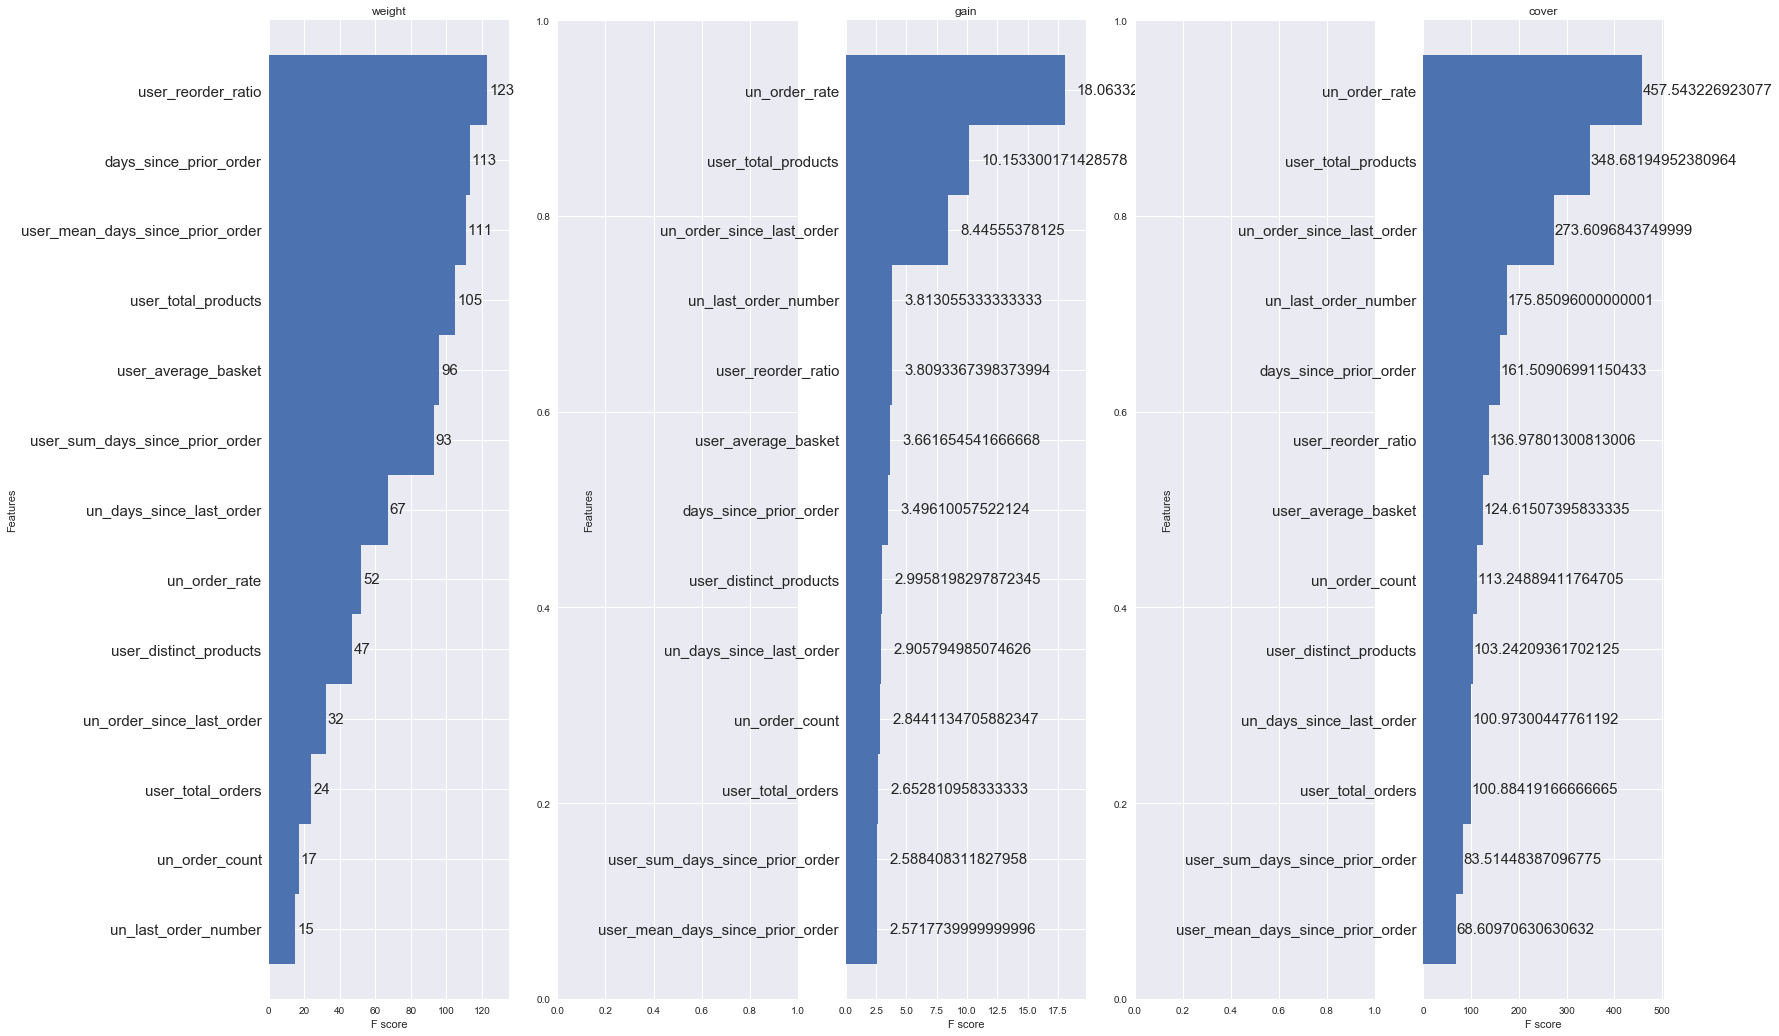

In [35]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,18))
measures = ['weight', 'gain', 'cover']
for i in range(3):
    plot_importance(bst, height=1, ax=axes[2*i], importance_type=measures[i], title=measures[i])
plt.show()

In [36]:
test_data.head()

,un_order_count,un_last_order_number,un_days_since_last_order,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,eval_set,days_since_prior_order,un_order_rate,un_order_since_last_order,is_none
1,1,1,NaN,4,15.0,5.000000,0.833333,22,7,5.500000,1980631,test,30.0,0.0,NaN,NaN
3,1,1,NaN,9,105.0,13.125000,0.739130,104,36,11.555556,2431024,test,7.0,0.0,NaN,NaN
5,1,1,NaN,8,174.0,24.857143,0.458333,67,45,8.375000,1099519,test,30.0,0.0,NaN,NaN
9,3,3,86.0,5,104.0,26.000000,0.280000,27,20,5.400000,3302990,test,30.0,0.5,2.0,NaN
16,2,2,60.0,3,60.0,30.000000,0.200000,8,7,2.666667,2587424,test,30.0,0.5,1.0,NaN


In [37]:
d_test = xgboost.DMatrix(test_data.drop(['eval_set', 'is_none', 'order_id'], axis=1))
test_data['is_none'] = bst.predict(d_test)

/Users/jiayou/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [40]:
test_data.describe()

,un_order_count,un_last_order_number,un_days_since_last_order,user_total_orders,user_sum_days_since_prior_order,user_mean_days_since_prior_order,user_reorder_ratio,user_total_products,user_distinct_products,user_average_basket,order_id,days_since_prior_order,un_order_rate,un_order_since_last_order,is_none
count,7536.000000,7536.000000,3307.000000,7536.00000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7536.000000,7.536000e+03,7536.000000,7536.000000,3307.000000,7536.000000
mean,1.901407,4.590366,99.682793,15.62646,155.546707,15.085207,0.490007,160.961518,65.546046,10.107185,1.692307e+06,16.949310,0.112028,8.699123,0.061440
std,1.565798,9.160418,85.513161,16.69177,102.856453,7.106586,0.214279,210.699615,56.966163,5.963427,9.854965e+05,10.652875,0.201375,13.054166,0.085902
min,1.000000,1.000000,0.000000,3.00000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,3.400000e+01,0.000000,0.000000,0.000000,0.007501
25%,1.000000,1.000000,32.000000,5.00000,66.000000,9.236842,0.335923,40.000000,26.000000,5.800000,8.384992e+05,7.000000,0.000000,1.000000,0.011070
50%,1.000000,1.000000,72.000000,9.00000,131.000000,14.414216,0.500000,84.000000,49.000000,9.000000,1.689198e+06,15.000000,0.000000,4.000000,0.023229
75%,2.000000,4.000000,140.500000,19.00000,234.000000,20.186364,0.653846,193.000000,89.000000,13.090909,2.535350e+06,30.000000,0.142857,11.000000,0.072233
max,30.000000,99.000000,363.000000,99.00000,365.000000,30.000000,1.000000,2306.000000,548.000000,46.755556,3.419878e+06,30.000000,1.000000,97.000000,0.646662


In [45]:
np.percentile(test_data.is_none, 99)

0.41713902503252009

In [46]:
prediction = test_data[['order_id', 'is_none']]
prediction.head()

,order_id,is_none
1,1980631,0.188252
3,2431024,0.007998
5,1099519,0.015688
9,3302990,0.199912
16,2587424,0.252907


In [47]:
prediction.to_csv(os.path.join(root, 'none_prediction.csv'), index = None)